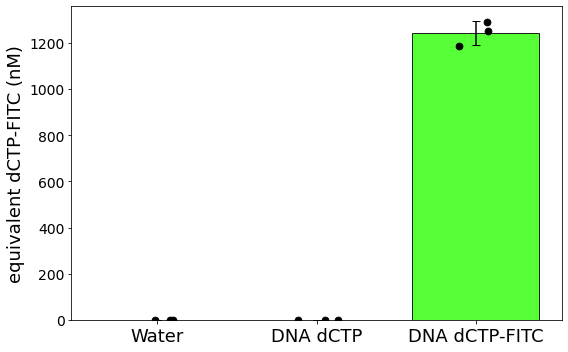

In [1]:
# Bar plot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----- Data -----
data = {
    "Water": [0.012744373, 0.012744373, 0.012744373],
    "DNA dCTP": [0.012744373, 0.012744373, 0.012744373],
    "DNA dCTP-FITC": [1289.60314, 1250.732801, 1187.138378],
}
df = pd.DataFrame(data, index=["rep1", "rep2", "rep3"])

# ----- Summary stats -----
means = df.mean(axis=0).values
stds = df.std(axis=0, ddof=1)  # sample SD
labels = df.columns.tolist()
x = np.arange(len(labels))
bar_width = 0.8

# ----- Plot -----
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x, means, bar_width, yerr=stds, capsize=4, alpha=0.85, edgecolor='0', color="#39FF14")

# Overlay individual points with slight jitter
rng = np.random.default_rng(42)
for i, label in enumerate(labels):
    y = df[label].values
    jitter = (rng.random(len(y)) - 0.5) * (bar_width * 0.35)
    ax.scatter(np.full_like(y, x[i]) + jitter, y, s=45, zorder=3, edgecolors='0', color='black')

ax.tick_params(axis='x', labelsize=16)   # X tick labels
ax.tick_params(axis='y', labelsize=14)   # Y tick labels

ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=18)
ax.set_ylabel("equivalent dCTP-FITC (nM)", fontsize=18)
#ax.set_title("Fluorescence by Condition (mean ± SD with replicates)")
ax.set_ylim(bottom=0)
ax.margins(x=0.05)
plt.tight_layout()

# Save
plt.savefig("fluorescence_barplot.svg", format="svg")
#plt.savefig("fluorescence_barplot.png", dpi=300)
plt.show()


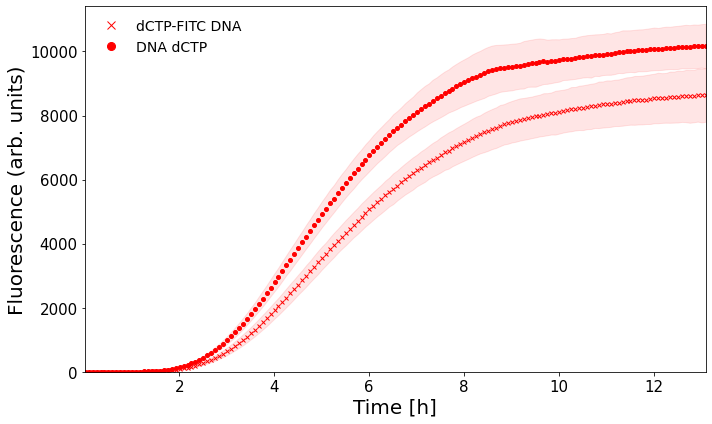

In [3]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as _dt

# ---------- File ----------
file_path = "mc expression from fluo dna.xlsx"
sheet_name = "plot"
df = pd.read_excel(file_path, sheet_name=sheet_name)

# ---------- Time → hours (robust) ----------
col = df["Time"]

if np.issubdtype(col.dtype, np.datetime64):
    t0 = pd.to_datetime(col.iloc[0])
    time_h = (pd.to_datetime(col) - t0).dt.total_seconds() / 3600.0
elif np.issubdtype(col.dtype, np.timedelta64):
    time_h = col.dt.total_seconds() / 3600.0
else:
    # Try parsing strings like "00:00:00"; if some are datetime.time, handle explicitly
    try:
        time_h = pd.to_timedelta(col).dt.total_seconds() / 3600.0
    except Exception:
        def _to_hours(v):
            if isinstance(v, _dt.time):
                return v.hour + v.minute/60 + v.second/3600
            try:
                return float(v)         # if already numeric hours
            except Exception:
                return np.nan
        time_h = col.apply(_to_hours)

# ---------- Group replicate columns ----------
# Matches "<condition> repN" (condition name can have spaces/dashes)
rep_regex = re.compile(r"^(?P<cond>.+?)\s+rep\d+$", re.IGNORECASE)

cond_to_cols = {}
for c in df.columns:
    if c == "Time":
        continue
    m = rep_regex.match(str(c))
    if m:
        cond = m.group("cond").strip()
        cond_to_cols.setdefault(cond, []).append(c)

# We expect exactly these two conditions:
expected = ["dCTP-FITC DNA", "DNA dCTP"]
conditions = [c for c in expected if c in cond_to_cols]
if len(conditions) < 2:
    raise ValueError(
        f"Could not find both expected conditions {expected}. "
        f"Found: {list(cond_to_cols.keys())}"
    )

# Sort replicate columns for consistency and ensure at least 2 (expecting 4)
for cond in conditions:
    cond_to_cols[cond] = sorted(cond_to_cols[cond])
    if len(cond_to_cols[cond]) < 2:
        raise ValueError(f"Condition '{cond}' has <2 replicate columns: {cond_to_cols[cond]}")

# ---------- Plot (aesthetics like your example) ----------
marker_fluo = ['rx', 'ro', 'rv', 'rD', 'rs', 'r*']  # red markers set
cond_markers = {conditions[0]: marker_fluo[0], conditions[1]: marker_fluo[1]}

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlabel('Time [h]', fontsize=20)
ax.tick_params(axis='x', labelsize=15)
ax.set_ylabel('Fluorescence (arb. units)', fontsize=20)
ax.tick_params(axis='y', labelsize=15)

for cond in conditions:
    cols = cond_to_cols[cond]
    y = df[cols].apply(pd.to_numeric, errors='coerce')  # coerce any stray text to NaN

    mean_fluo = y.mean(axis=1)
    std_fluo  = y.std(axis=1, ddof=1)

    # Red line + distinct red marker per condition
    ax.plot(time_h, mean_fluo, cond_markers[cond], ms=4, lw=1.5, label=cond)
    # Red shaded SD (like your example)
    ax.fill_between(time_h, mean_fluo - std_fluo, mean_fluo + std_fluo, alpha=0.10, color='red')

ax.legend(fontsize=14, loc='upper left', markerscale=2, frameon=False)
ax.set_xlim(time_h.min(), time_h.max())
ax.set_ylim(bottom=0)
plt.tight_layout()

# Optional save:
#plt.savefig("dCTP_expression_kinetics.svg", format="svg")
plt.show()
